# IDEO Challenge: Chicago 'L' Ridership
    Author: Kris Darnell
    Date: April 3, 2018
    
* In this notebook I will do the following things:
    1. Load data from https://data.cityofchicago.org/Transportation/CTA-Ridership-L-Station-Entries-Daily-Totals/5neh-572f  
    2. Inspect and manipulate data.
    3. Answer initial questions:
        * **Q -- Which stop has the highest average ridership per day, and what is it?**    
            A -- station_id=40380 (Clark/Lake) @ 13,830 riders per day  
            A -- This is probably because this stop is within the loop where there is a high population density and has easy access to all lines.
        * **Q -- Which stop has the greatest standard deviation in weekday (exclude holidays) ridership per day, and what is it? What’s your hypothesis for why?**  
            A -- Most robust answer: station_id=41660 (State/Lake) @ +/- 4,404 riders per day  
            A -- There seems to be a seasonal cycle associated with ridership. My hypothesis is that since this stop is located downtown, then ridership significantly decreases during the Thanksgiving/Christmas/New Year's holiday season because so many people are on vacation.  
            Note:  
            A -- Purely on a statistical basis: station_id=41700 (Washington/Wabash) @ +/- 4,444 riders per day  
            (However, this seems to actually result from lots of days that exist in the data with zero riders. If we account for those, the standard deviation is more like +/- 436 riders per day).  
    4. Answer challenge question: 
        * I will select Intelligentsia Coffee as a business to assist in opening a new location.
        * I will evaluate the distance between each location and the proximity of stations to each location.
        * Merged data with additional station data from https://data.cityofchicago.org/Transportation/CTA-System-Information-List-of-L-Stops/8pix-ypme

# 0. Perform analysis in Python and load relevant libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium import plugins
%matplotlib inline

# 1. Load data

In [2]:
df = pd.read_csv('CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')

# 2. Inspect and manipulate data

In [3]:
df.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,01/01/2001,U,290
1,40020,Harlem-Lake,01/01/2001,U,633
2,40030,Pulaski-Lake,01/01/2001,U,483
3,40040,Quincy/Wells,01/01/2001,U,374
4,40050,Davis,01/01/2001,U,804


**We have five rows. Three are self-explanatory. Daytype is encoded as follows: "W" for Weekday, "A" for Saturday and "U" for Sunday/Holidays**

In [4]:
print('Unique "station_id":\n {0}\n'.format(df.station_id.unique()))
print('Total number of "station_id":\n {0}'.format(len(df.station_id.unique())))

print('\nUnique "stationname":\n {0}\n'.format(df.stationname.unique()))
print('Total number of "stationname":\n {0}'.format(len(df.stationname.unique())))

Unique "station_id":
 [40010 40020 40030 40040 40050 40060 40070 40080 40090 40100 40120 40130
 40140 40150 40160 40170 40180 40190 40200 40210 40220 40230 40240 40250
 40260 40270 40280 40290 40300 40310 40320 40330 40340 40350 40360 40370
 40380 40390 40400 40420 40430 40440 40450 40460 40470 40480 40490 40500
 40510 40520 40530 40540 40550 40560 40570 40580 40590 40600 40610 40630
 40640 40650 40660 40670 40680 40690 40700 40710 40720 40730 40740 40750
 40760 40770 40780 40790 40800 40810 40820 40830 40840 40850 40870 40880
 40890 40900 40910 40920 40930 40940 40960 40970 40980 40990 41000 41010
 41020 41030 41040 41050 41060 41070 41080 41090 41120 41130 41140 41150
 41160 41170 41180 41190 41200 41210 41220 41230 41240 41250 41260 41270
 41280 41290 41300 41310 41320 41330 41340 41350 41360 41380 41400 41410
 41420 41430 41440 41450 41460 41480 41490 41500 41660 41670 41580 41680
 41510 41690 41700]

Total number of "station_id":
 147

Unique "stationname":
 ['Austin-Forest Park' 

**It looks like there is one station id with two names. Let's inspect.**

In [5]:
df.groupby('station_id').apply(lambda x: len(x['stationname'].unique())).sort_values(ascending=False).head()

station_id
40140    2
41700    1
40490    1
40550    1
40540    1
dtype: int64

In [6]:
df[df['station_id'] == 40140]['stationname'].unique()

array(['Skokie', 'Dempster-Skokie'], dtype=object)

** This name must have been changed at some point. We will use station_id for all important analysis**

**Let's insert context on month, day, and year in case we need it later by converting date to a 'datetime' object and selecting relevant attributes.**

In [7]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].map(lambda x: x.year)
df['month'] = df['date'].map(lambda x: x.month)
df['day'] = df['date'].map(lambda x: x.day)
df['dayofweek'] = df['date'].map(lambda x: x.dayofweek)

In [8]:
df.head()

,station_id,stationname,date,daytype,rides,year,month,day,dayofweek
0,40010,Austin-Forest Park,2001-01-01,U,290,2001,1,1,0
1,40020,Harlem-Lake,2001-01-01,U,633,2001,1,1,0
2,40030,Pulaski-Lake,2001-01-01,U,483,2001,1,1,0
3,40040,Quincy/Wells,2001-01-01,U,374,2001,1,1,0
4,40050,Davis,2001-01-01,U,804,2001,1,1,0


# 3. Answer initial questions

**Which stations have the highest average ridership?**

In [9]:
avgd = df.groupby(['station_id', 'stationname'])['rides'].agg(np.mean).sort_values(ascending=False).reset_index()
avgd.head()

,station_id,stationname,rides
0,40380,Clark/Lake,13829.990290
1,41660,Lake/State,13597.645469
2,41450,Chicago/State,12980.024603
3,40450,95th/Dan Ryan,10747.604746
4,41320,Belmont-North Main,10474.624474


**Which stations have the highest standard deviation on weekday  ridership?**

In [10]:
weekday = df[df['daytype'] == 'W'].reset_index(drop=True)
weekday_std = weekday.groupby(['station_id', 'stationname'])['rides'].agg(np.std).sort_values(ascending=False)
weekday_std.head()

station_id  stationname       
41700       Washington/Wabash     4444.285216
41660       Lake/State            4404.533162
40500       Washington/State      3890.640503
41420       Addison-North Main    3340.840841
40380       Clark/Lake            2836.839917
Name: rides, dtype: float64

## Let's inspect the top stations to see if there are any obvious trends.

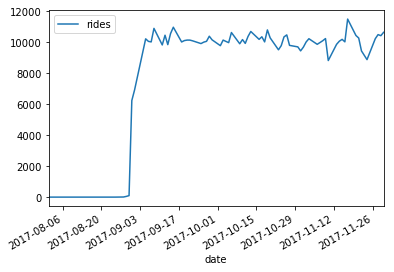

In [11]:
weekday[weekday['station_id'] == 41700].plot('date', 'rides')
plt.show()

**There is a lot of data where there are zero riders. Simple research shows that this is a new station that openeed last year. Let's isolate the data from when the station was fully operational**

In [12]:
weekday[(weekday['station_id'] == 41700) & (weekday['rides'] > 0)].head(10)

,station_id,stationname,date,daytype,rides,year,month,day,dayofweek
605470,41700,Washington/Wabash,2017-08-28,W,7,2017,8,28,0
605471,41700,Washington/Wabash,2017-08-29,W,45,2017,8,29,1
605472,41700,Washington/Wabash,2017-08-30,W,96,2017,8,30,2
605473,41700,Washington/Wabash,2017-08-31,W,6244,2017,8,31,3
608354,41700,Washington/Wabash,2017-09-01,W,6932,2017,9,1,4
608355,41700,Washington/Wabash,2017-09-05,W,10233,2017,9,5,1
608356,41700,Washington/Wabash,2017-09-06,W,10068,2017,9,6,2
608357,41700,Washington/Wabash,2017-09-07,W,10034,2017,9,7,3
608358,41700,Washington/Wabash,2017-09-08,W,10908,2017,9,8,4
608359,41700,Washington/Wabash,2017-09-11,W,9838,2017,9,11,0


**Use data after September 5th of 2017**

In [13]:
weekday[(weekday['station_id'] == 41700) & (weekday['date'] > '2017-09-05')]['rides'].std()

436.44033950284114

**This significantly alters the result above. Let's look at the second station in that list**

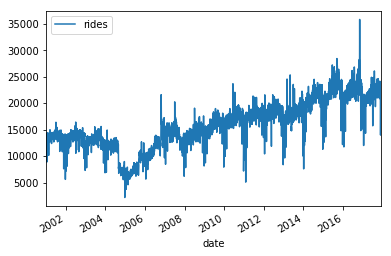

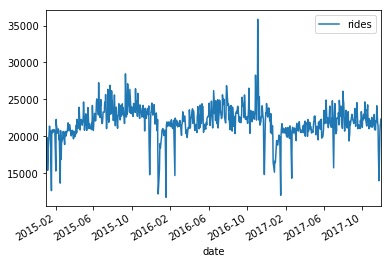

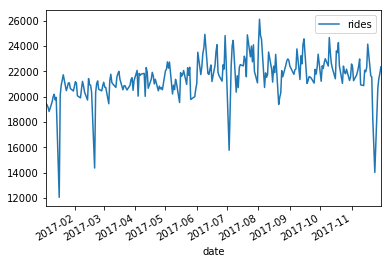

,rides
dayofweek,
0,4263.384020
1,4249.060013
2,4307.225324
3,4388.932881
4,4736.819267


In [14]:
weekday[weekday['station_id'] == 41660].plot('date', 'rides')
plt.show()

weekday[(weekday['station_id'] == 41660) & (weekday['year'] > 2014)].plot('date', 'rides')
plt.show()

weekday[(weekday['station_id'] == 41660) & (weekday['year'] > 2016)].plot('date', 'rides')
plt.show()

weekday[weekday['station_id'] == 41660][['rides', 'dayofweek']].groupby('dayofweek').agg(np.std)

**There appears to be a seasonal dependence rather than a weekly dependence. There is also a signficant trend in the data. A more thorough analysis would try to limit this trend or better understand the context of the question**

# 4. Challenge Question.

I will select **Intelligentsia Coffee** as my client due to my love for coffee.

* What questions could you potentially explore/answer with this data?
    1. We could use this data to help Intelligentsia find a new location that has the highest ridership, but is also the farthest distance from any of their other locations or is an area under-served with respect to competitors.
    2. We could use this data to help Intelligentsia find a new location at a station where ridership is steadily on the rise and is currently under-served with regards to coffee shops.
* Ideally, what other data would you gather or combine to learn even more?
    1. We would want to understand the demographics of Intelligentsia customers and compare with the demographics of riders passing through that station. Alternatively, we would want to understand the demographics of residents near to that station. 
    2. We would want to compare the Intelligentsia hours of operation with the time of day ridership statistics. I would hypothesize that Intelligentsia would want to be near a station that had steady ridership throughout the day including during the night.
    3. If we were interested in projecting the increase in ridership at stations, we might also want to understand how home sale prices might be changing or how population shifts or new construction in the neighborhood might be driving increased ridership.
    4. We would also want to understand the competition in the area. This might require scraping data to find out where all the other coffee shops in the city were located.
* How would you want to see data presented, to make it actionable by you or others?
    1. This certainly depends on the type of question being asked, but at the least I would want to see a map of Chicago with the Intelligentsia locations pinned and then the candidate stations shown with additional information available.  
    2. In this context, I would want the map to be interactive so that I could understand details about each station without excessive effort. Perhaps we could encode options for the user to turn on/off specific lines or display statistics vs. time series plots when we clicked on each station.
    3. If we were interested in distances to stations, I could imagine scatter plots that tried to rank competing features of each station. For example, we might want to look at distance from each station to an existing Intelligentsia location vs. average daily ridership or distance vs. projected yearly increase in average daily ridership.
* How could an algorithm or model be used? How might your client interact with that algorithm or model?
    1. Models require the prediction of some value. In the context of this question, the most obvious predictor would be the daily ridership on a particular day or the yearly average of daily ridership. We could build a simple regression model to predict ridership.
    2. Clients could interact with such a model through the use of some type of slider. The slider could be used to select a future date with the predicted ridership at each station displayed. 

# Develop interactive plots:
* I will use a mapping toolbox to plot Intelligentsia locations and display stations with station characterstics embedded.

# Load packages

In [15]:
from geopy.geocoders import Nominatim
import folium

# These are the addresses of Intelligentsia locations taken from yelp

In [16]:
ic_adds = ["53 E Randolph St, Chicago, IL 60601",
           "53 W Jackson Blvd, Chicago, IL 60604",
           "3123 North Broadway, Chicago, IL 60657",
           "1233 N Wells St, Chicago, IL 60610",
           "1609 W Division St, Chicago, IL 60622",
           "2642 N Milwaukee Ave, Chicago, IL 60647"] 

# Convert addresses to latitude and longitude coordinates

In [17]:
geolocator = Nominatim()
ic_lat, ic_lon = [],[]
for address in ic_adds:
    location = geolocator.geocode(address)
    ic_lat.append(location.latitude)
    ic_lon.append(location.longitude)
ic_lat, ic_lon = np.asarray(ic_lat), np.asarray(ic_lon)

# Load map and center map on the centroid of the Intelligentsia locations

In [18]:
m = folium.Map(location=[np.mean(ic_lat),
                         np.mean(ic_lon)],
               zoom_start=13,
               tiles="OpenStreetMap")
m

# Display Intelligentsia locations and provide click functionality to display location address

In [19]:
for index, coords in enumerate(zip(ic_lat, ic_lon)):
    folium.Marker([coords[0], coords[1]],
                        popup=ic_adds[index],
                       ).add_to(m)
m

# Load additional data from CTA system to gather coordinates of each station

In [20]:
df2 = pd.read_csv('CTA_-_System_Information_-_List_of__L__Stops.csv')
station_locs = df2.groupby('MAP_ID')[['STATION_NAME', 'Location']].first().reset_index()
station_locs['Latitude'] = station_locs['Location'].apply(lambda x: float(x.split(',')[0][1:]))
station_locs['Longitude'] = station_locs['Location'].apply(lambda x: float(x.split(',')[1][:-1]))
station_locs.head()

,MAP_ID,STATION_NAME,Location,Latitude,Longitude
0,40010,Austin,"(41.870851, -87.776812)",41.870851,-87.776812
1,40020,Harlem/Lake,"(41.886848, -87.803176)",41.886848,-87.803176
2,40030,Pulaski,"(41.885412, -87.725404)",41.885412,-87.725404
3,40040,Quincy/Wells,"(41.878723, -87.63374)",41.878723,-87.633740
4,40050,Davis,"(42.04771, -87.683543)",42.047710,-87.683543


# Merge new data with the averaged daily ridership of the original data

In [21]:
df_new = station_locs.set_index('MAP_ID').join(avgd.set_index('station_id')).reset_index()
df_new.rename(columns={'index': 'station_id'}, inplace=True)
df_new['rides_scale'] = df_new['rides'] / df_new['rides'].mean()
df_new.head()

,station_id,STATION_NAME,Location,Latitude,Longitude,stationname,rides,rides_scale
0,40010,Austin,"(41.870851, -87.776812)",41.870851,-87.776812,Austin-Forest Park,1536.416437,0.471205
1,40020,Harlem/Lake,"(41.886848, -87.803176)",41.886848,-87.803176,Harlem-Lake,3094.157282,0.948950
2,40030,Pulaski,"(41.885412, -87.725404)",41.885412,-87.725404,Pulaski-Lake,1436.182215,0.440464
3,40040,Quincy/Wells,"(41.878723, -87.63374)",41.878723,-87.633740,Quincy/Wells,5624.562288,1.725003
4,40050,Davis,"(42.04771, -87.683543)",42.047710,-87.683543,Davis,3321.967956,1.018818


# Display each station and encode statistics
## In this first cut, I will use the size of the station marker to indicate the relative daily ridership total

In [22]:
for index, data in df_new.iterrows():
    if data['STATION_NAME'] == "O'Hare":
        label='OHare'
    else:
        label = data['STATION_NAME']
    label += '(' + str(data['station_id']) + '), ' + str(np.round(data['rides'],0)) + ' riders per day'
    folium.CircleMarker(location=[data['Latitude'], data['Longitude']],
                            radius=10*data['rides_scale'],
                            fill_color="red",
                            fill=True,
                            popup=label,
                           ).add_to(m)
m

# Now let's import a package to calculate distances based on coordinates

In [23]:
from geopy.distance import vincenty

'''
Define a function that calculates the minimum distance 
between a station and all of the Intelligentsia coffee shops
'''
def min_dist_to_loc(ic_locs, station_loc):
    dists = []
    for loc in ic_locs:
        dists.append(vincenty(loc, station_loc).miles)
    return min(dists)

In [24]:
'''
Determine average distance between shops as a scaling factor.
'''
ic_dists = []
for ii in range(len(ic_lat)):
    for jj in range(len(ic_lat)):
        if jj != ii:
            ic_dists.append(vincenty((ic_lat[ii], ic_lon[ii]), 
                                     (ic_lat[jj], ic_lon[jj])).miles)
avg_dist_to_self = np.mean(ic_dists)

# Determine minimum distance from the station to the nearest location

In [25]:
df_new['dist_to_loc'] = df_new.apply(lambda x: 
                                     min_dist_to_loc(zip(ic_lat, ic_lon), 
                                                     (x['Latitude'], x['Longitude'])), 
                                     axis=1)
df_new['dist_scale'] = df_new['dist_to_loc'] / avg_dist_to_self


# Develop simple metric that weights distance and ridership equally

In [26]:
df_new['dist&ride_metric'] = df_new['rides_scale'] * df_new['dist_scale']
df_new.head()

,station_id,STATION_NAME,Location,Latitude,Longitude,stationname,rides,rides_scale,dist_to_loc,dist_scale,dist&ride_metric
0,40010,Austin,"(41.870851, -87.776812)",41.870851,-87.776812,Austin-Forest Park,1536.416437,0.471205,5.372258,1.789386,0.843168
1,40020,Harlem/Lake,"(41.886848, -87.803176)",41.886848,-87.803176,Harlem-Lake,3094.157282,0.948950,5.702457,1.899368,1.802406
2,40030,Pulaski,"(41.885412, -87.725404)",41.885412,-87.725404,Pulaski-Lake,1436.182215,0.440464,3.176300,1.057959,0.465993
3,40040,Quincy/Wells,"(41.878723, -87.63374)",41.878723,-87.633740,Quincy/Wells,5624.562288,1.725003,0.231079,0.076968,0.132769
4,40050,Davis,"(42.04771, -87.683543)",42.047710,-87.683543,Davis,3321.967956,1.018818,7.820785,2.604939,2.653958


# Plot the ridership versus the distance

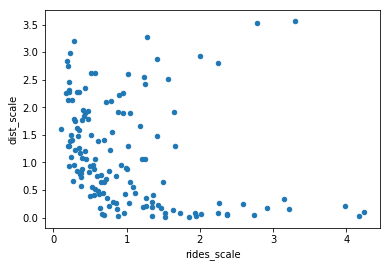

In [27]:
df_new.plot('rides_scale', 'dist_scale', kind='scatter')

**It seem like there are high ridership stations very close to stations and also at the far end of the lines with a lot more interspersed. Let's make one more map to visualize.**

# Make new map with station size as the new metric which highlights stations far from existing stations that also have high ridership.
* Note: On click -- the ridership and distance to closest location are displayed.

In [29]:
m2 = folium.Map(location=[np.mean(ic_lat),
                         np.mean(ic_lon)],
               zoom_start=12,
               tiles="OpenStreetMap")
for index, coords in enumerate(zip(ic_lat, ic_lon)):
    folium.Marker([coords[0], coords[1]],
                        popup=ic_adds[index],
                       ).add_to(m2)
for index, data in df_new.iterrows():
    if data['STATION_NAME'] == "O'Hare":
        label='OHare'
    else:
        label = data['STATION_NAME']
    label += ('(' + str(data['station_id']) + '), ' 
              + str(np.round(data['rides'],0)) + ' riders per day, '
              + str(np.round(data['dist_to_loc'],2)) + ' miles to nearest')
    folium.CircleMarker(location=[data['Latitude'], data['Longitude']],
                        radius=10*data['dist&ride_metric'],
                        fill_color="black",
                        fill=True,
                        popup=label,
                       ).add_to(m2)
m2

# It looks like there may be four significant candidates. 
1. The Wilson station is far (1.92 miles to nearest) from existing shops and has ~5,000 daily riders.
2. The Fullerton station is somewhat far (1.01 miles to nearest) from existing shops and has ~10,000 daily riders.
3. The Chicago station is reasonably far (0.65 miles to nearest) from existing shops and has ~13,000 daily riders
4. The Roosevelt station is reasonably far (0.72 miles to nearest) from existing shops and has ~8,500 daily riders.

# Concluding remarks:
With infinite time we could:
   * Incorporate additional details about these stations (expected ridership increase in coming years), the neighborhood demographics (salary distribution, age distribution, etc.), and the competitive landscape (number of competing coffee shops, number of coffees purchased in the area on a daily basis, etc.)
   * Add more layers and options to the map.
   * Talk with the client about what was most important to them and what might drive their choices in location.